In [2]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

In [3]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        legendfont = font("CMU Serif", 18),
        colorbar_tickfontsize = 18,
        colorbar_titlefontsize = 18,
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [4]:
function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

In [5]:
function routine_plot(state, config::VortexConfig)
    source = state_to_lagrange(state, config)
    plt = plot(layout = grid(1,2))
    
    zc = mean(getfield.(source[1], :z))
    plot!(plt[1,1], size = (1000, 400), xlabel = L"x", ylabel = L"y")
    plot!(plt[1,1], xlims = (-2.0, 10.0), 
                      ylim = (-2, 2))
    plot!(plt[1,1], source, ratio = 1.0, legend = false, markersize = 5, color = cgrad([:blue; :white; :red]))
    scatter!(plt[1,1], real.(config.ss), imag.(config.ss), markersize = 5, color = colorant"orangered2")
    
    plot!(plt[1,2], xlims = (real(zc) - 2.0, real(zc) + 2.0), 
                      ylim = (-2, 2))
    plot!(plt[1,2], source, ratio = 1.0, legend = false, markersize = 5, color = cgrad([:blue; :white; :red]))

end

routine_plot (generic function with 1 method)

In [6]:
"""
    vortex_patch!(vort,zc,Γ,radius,nring[,δ=0])

Create a circular patch of vortex blobs, returned in `vort`. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `δ`, which is 0 by default.
"""
function vortex_patch!(vort,zc,Γ,radius,nring::Int;δ=0)
    Δr = radius/(nring-1/2)
    dΓ = Γ/(1+8*nring*(nring-1)/2)
    @show dΓ
    push!(vort,Vortex.Blob(zc,dΓ,δ))
    for ir in 1:nring-1
        nθ = 8*ir
        for j = 0:nθ-1
            push!(vort,Vortex.Blob(zc + ir*Δr*exp(im*2π*j/nθ),dΓ,δ))
        end
    end
    return vort
end

"""
    vortex_patch(zc,Γ,radius,nring[,δ=0]) -> Vector{Vortex.Blob}

Create a circular patch of vortex blobs. The centroid of the patch is at `zc`, its strength
(circulation) is `Γ`, and its radius is `radius`. The patch consists of `nring` rings; if `nring = 1`, the patch
consists of only a single vortex blob at the centroid. Each blob is assigned radius `δ`, which is 0 by default.
"""
vortex_patch(zc,Γ,radius,nring::Int;δ=0) = vortex_patch!(Vortex.Blob{Float64,Float64}[],zc,Γ,radius,nring,δ=δ)

vortex_patch

### Configuration setup

In [7]:
#
Δtgif = 0.5

# Pressure sensors
Δs = 0.5
sensors = complex.(collect(-1.5:Δs:10.0))
Ny = length(sensors)


rpatch = 0.5 # initial radius of the vortex patch
dpatch = 1.2 # initial distance between patch centroids
Γpatch = 6.0 # strength of patch.
Upatch = Γpatch/(2*π*dpatch)
Nring = 4  # number of rings in each patch.
# The uncertainty is set to a small fraction 10% of the Δr between two consecutive rings
σr =  0.1*rpatch/(Nring-1/2)
σΓ =  1e-2
# Δt = 0.01#0.005*π^2*d0^2/abs(Γ0) # set the time step


config_data = let Nv = 1+(8*(Nring-1)*Nring)÷2, 
             ss = sensors, Δt = 5e-3, δ = 5e-2,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 2e-1
    VortexConfig(Nv, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-2, 10, length= 800)
ygrid = range(-2, 2, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

In [8]:
blobsmean = vortex_patch(im*dpatch/2, Γpatch, rpatch, Nring, δ = config_data.δ)

zmean = getfield.(blobsmean, :z)
Γmean = getfield.(blobsmean, :S);

dΓ = 0.12244897959183673


In [9]:
Re = 300
gridRe = 3

idxCFD = Int64[]

ssCFD = -1.5:0.01:11
NCFD = length(ssCFD)

for (i, xi) in enumerate(ssCFD)
    if sum(xi .∈ config_data.ss) == 1
        push!(idxCFD, copy(i))
    elseif sum(xi .∈ config_data.ss) == 2
        error()
    end
end

@assert ssCFD[idxCFD] == config_data.ss "Error in the selected sensors"

fullpress = load("/media/mat/HDD/VortexPatch.jl/notebooks/data/pressure_vortex_patch_CFD_t_"*
    string(ceil(Int64, tspan[end]))*"_Re_"*string(ceil(Int64, Re))*
                 "_gridRe_"*string(ceil(Int64, gridRe))*"_rpatch_"*string(ceil(Int64, 100*rpatch))*
                 "_dpatch_"*string(ceil(Int64, 100*dpatch))*
                 "_Gpatch_"*string(ceil(Int64, 100*Γpatch))*"_2.jld")["p"]

yt = fullpress[idxCFD, :]


ΔtCFD = 5e-3
data = SyntheticData(collect(0.0:ΔtCFD:12.0), ΔtCFD, zeros(1), zeros(1, length(collect(0.0:ΔtCFD:12.0))), yt)

SyntheticData([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045  …  11.955, 11.96, 11.965, 11.97, 11.975, 11.98, 11.985, 11.99, 11.995, 12.0], 0.005, [0.0], [0.0 0.0 … 0.0 0.0], [0.22771134831825499 0.22057070571050047 … 0.008315817597762655 0.008310280891028888; 0.26806716502559724 0.2592128691893036 … 0.009241661551845552 0.009235187666125745; … ; 0.010517743253379931 0.010538695608632083 … 0.17923073111241095 0.17932708824712199; 0.009571049008478959 0.009585264606603146 … 0.13811987319848656 0.13835619839202318])

In [10]:
# plot(M1cfd[2,:])

### Setup the sequential filter

In [11]:
# config = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [1.0], U = complex(1.0), 
#              ss = sensors, Δt = 1e-2, δ = 1e-2,
#              ϵX = 5e-3, ϵΓ = 5e-3, ϵQ = 5e-3,
#              β = 1.0,
#              ϵY = 1e-2
#     VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
# end

config = deepcopy(config_data)

VortexConfig(49, ComplexF64[-1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im, 3.0 + 0.0im  …  5.5 + 0.0im, 6.0 + 0.0im, 6.5 + 0.0im, 7.0 + 0.0im, 7.5 + 0.0im, 8.0 + 0.0im, 8.5 + 0.0im, 9.0 + 0.0im, 9.5 + 0.0im, 10.0 + 0.0im], 0.005, 0.05, 0.0001, 0.0001, 1.0, 0.2)

In [12]:
# ϵX0 = 0.001
# ϵΓ0 = 0.001
# ϵQ0 = 0.001

# ϵ0 = RecipeInflation([ϵX0; ϵΓ0; ϵQ0])

ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(24, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

In [13]:
enkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

Stochastic EnKF  with filtered = true


In [14]:
# Generate the initial condition

Ne = 30
Nx = 3*config.Nv
Ny = length(config.ss)

X0 = zeros(Ny+Nx, Ne)

for k=1:Ne
    for i=1:config.Nv
        # Perturbed position 
        zi = zmean[i] + σr*randn()*exp(im*π*rand())
        X0[Ny + 3*(i-1) + 1, k] = real(zi)
        X0[Ny + 3*(i-1) + 2, k] = imag(zi)
        # Perturbed circulation
        Γi = Γmean[i] + σΓ*randn()
        X0[Ny + 3*(i-1) + 3, k] = Γi
    end
end

In [15]:
# Xf, Xa = symmetric_vortexassim(enkf, deepcopy(X0), tspan, config, data; P = serial);

In [16]:
# save("ensemble_EnKF_Ne_"*string(Ne)*".jld", "Xf", Xf, "Xa", Xa)


Xf = load("ensemble_EnKF_Ne_"*string(Ne)*".jld")["Xf"]
Xa = load("ensemble_EnKF_Ne_"*string(Ne)*".jld")["Xa"];

In [17]:
# Xflowrank, Xalowrank,rxhist, ryhist = adaptive_symmetric_lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
#                                                   rxdefault = 20, rydefault = 4, P = serial, isadaptive = true);

In [18]:
# save("ensemble_lowrank_Ne_"*string(Ne)*".jld", "Xf", Xflowrank, "Xa", Xalowrank)

Xflowrank = load("ensemble_lowrank_Ne_"*string(Ne)*".jld")["Xf"]
Xalowrank = load("ensemble_lowrank_Ne_"*string(Ne)*".jld")["Xa"];

### Figure pressure

In [25]:
# # Compute the estimate pressure
# p_lowrank = zeros(length(ssCFD), length(1:2401))
# @showprogress for i = 1:2401
#     @assert config.Δt == data.Δt 
#     X_lowrank = deepcopy(Xalowrank[i])
#     Y_lowrank = zeros(NCFD, Ne)

#     ϵx = RecipeInflation([config.ϵX; config.ϵΓ])
#     ϵmul = MultiplicativeInflation(config.β)

#     # Perform state inflation
#     ϵmul(X_lowrank, 1, Nx)
#     ϵx(X_lowrank, 0, Nx, config)
#     for i=1:Ne
#         Y_lowrank[:,i] .= symmetric_pressure(collect(ssCFD), 
#                            vcat(state_to_lagrange(X_lowrank[:,i], config)...), 0.0)#.+ config.ϵY*randn(NCFD)
#     end

#     q50_lowrank = median(Y_lowrank; dims = 2)[:,1]
#     p_lowrank[:,i] .= deepcopy(q50_lowrank)
# end

In [26]:
# save("pressure_lowrank_Ne_"*string(Ne)*".jld", "p", p_lowrank)
p_lowrank = load("pressure_lowrank_Ne_"*string(Ne)*".jld", "p");

In [27]:
# # Compute the estimate pressure
# p_enkf = zeros(length(ssCFD), length(1:2401))
# @showprogress for i = 1:2401
#     @assert config.Δt == data.Δt 
#     idxCFD = deepcopy(i)
#     X_enkf = deepcopy(Xa[i])
#     Y_enkf = zeros(NCFD, Ne)

#     ϵx = RecipeInflation([config.ϵX; config.ϵΓ])
#     ϵmul = MultiplicativeInflation(config.β)

#     # Perform state inflation
#     ϵmul(X_enkf, 1, Nx)
#     ϵx(X_enkf, 0, Nx, config)
#     for i=1:Ne
#         Y_enkf[:,i] .= symmetric_pressure(collect(ssCFD), 
#                            vcat(state_to_lagrange(X_enkf[:,i], config)...), 0.0)#.+ config.ϵY*randn(NCFD)
#     end

#     q50_enkf = median(Y_enkf; dims = 2)[:,1]
#     p_enkf[:,i] .= deepcopy(q50_enkf)
# end

In [28]:
# save("pressure_EnKF_Ne_"*string(Ne)*".jld", "p", p_enkf)
p_enkf = load("pressure_EnKF_Ne_"*string(Ne)*".jld", "p");

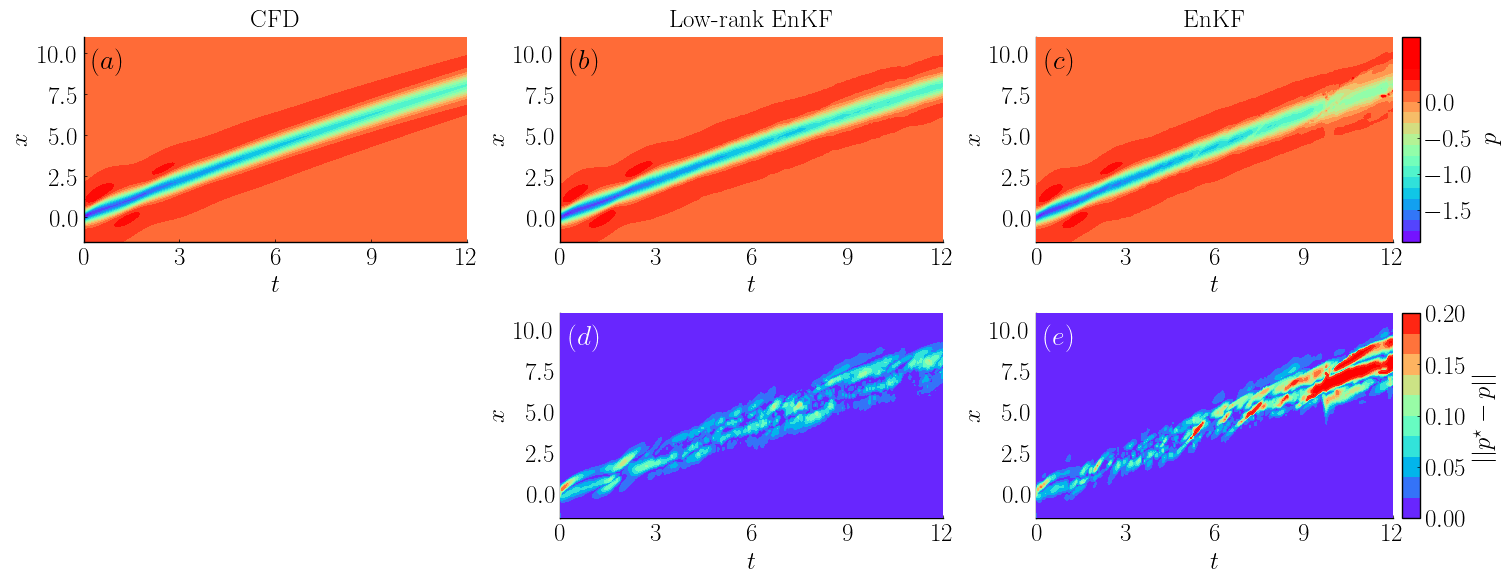

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [29]:
Δstep = 10;

plt = plot(layout = grid(2, 3), xlabel = L"t", ylabel = L"x", 
           xticks = collect(0.0:3.0:12.0), size = (1500, 600))

tlist = 0.0:config.Δt:12.0

for i=1:3
    plot!(plt[1,i], topmargin = 60*Plots.px)
end

for j=1:2
    plot!(plt[j,3], rightmargin = -100Plots.px)
end

annotate!(plt[1,1], 6.0, 12.0, "CFD")
annotate!(plt[1,2], 6.0, 12.0, "Low-rank EnKF")
annotate!(plt[1,3], 6.0, 12.0, "EnKF")

# Plot presssure from CFD
contourf!(plt[1,1], tlist[1:Δstep:end], ssCFD[1:Δstep:end], fullpress[1:Δstep:end,1:Δstep:end], 
         color = :rainbow1,#reverse(cgrad(:viridis)),
         colorbar = false,
         levels = 20,
#          levels = 0.0:0.005:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(findmin(fullpress)[1], findmax(fullpress)[1]), colorbar_title = L"p")

annotate!(plt[1,1], 0.8, 9.5, text(L"(a)", :black, 20))


# Plot presssure from lowrank
contourf!(plt[1,2], tlist[1:Δstep:end], ssCFD[1:Δstep:end], 0.25*p_lowrank[1:Δstep:end,1:Δstep:end], 
         color = :rainbow1,#reverse(cgrad(:viridis)),
         colorbar = false,
         levels = 20, 
#          levels = 0.0:0.005:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(findmin(fullpress)[1], findmax(fullpress)[1]), colorbar_title = L"p")
annotate!(plt[1,2], 0.8, 9.5, text(L"(b)", :black, 20))

# Plot error from lowrank
contourf!(plt[2,2], tlist[1:Δstep:end], ssCFD[1:Δstep:end], 
         abs.(0.25*p_lowrank[1:Δstep:end,1:Δstep:end]-fullpress[1:Δstep:end,1:Δstep:end]), 
         color = :rainbow1,#dense,#:linear_worb_100_25_c53_n256,#reverse(cgrad(:grays)),
         colorbar = false,
         levels = 0.0:0.02:0.2,
         background_color_inside = cgrad(:dense)[end],
         clims =(0.0, 0.2), colorbar_title = L"||p^\star - p||")
annotate!(plt[2,2], 0.8, 9.5, text(L"(d)", :white, 20))

plot!(plt[2,1], axis = false, xlabel = "", ylabel = "")

# Plot presssure from enkf
contourf!(plt[1,3], tlist[1:Δstep:end], ssCFD[1:Δstep:end], 0.25*p_enkf[1:Δstep:end,1:Δstep:end], 
         color = :rainbow1,#reverse(cgrad(:viridis)),
         levels = 20, 
#          levels = 0.0:0.005:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(findmin(fullpress)[1], findmax(fullpress)[1]), colorbar_title = L"p")
annotate!(plt[1,3], 0.8, 9.5, text(L"(c)", :black, 20))


contourf!(plt[2,3], tlist[1:Δstep:end], ssCFD[1:Δstep:end], 
         abs.(0.25*p_enkf[1:Δstep:end,1:Δstep:end]-fullpress[1:Δstep:end,1:Δstep:end]), 
         color = :rainbow1,#dense,#:linear_worb_100_25_c53_n256,#reverse(cgrad(:grays)),
         levels = 0.0:0.02:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(0.0, 0.2), colorbar_title = L"||p^\star - p||")
annotate!(plt[2,3], 0.8, 9.5, text(L"(e)", :white, 20))


savefig("comparison_pressure.pdf")

In [45]:
c_enkf = colorant"cornflowerblue"
c_lowrank_85 = colorant"gold"
c_lowrank = colorant"tomato2"
c_cfd = colorant"seagreen3"

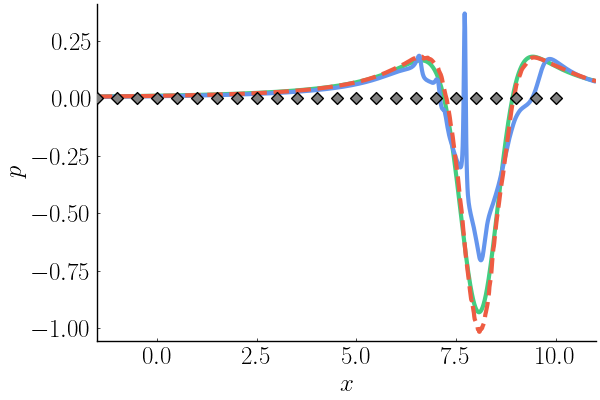

In [53]:
plt = plot(xlabel = L"x", ylabel = L"p", xlims = (-Inf, Inf))

plot!(plt, ssCFD, fullpress[:,end], linewidth = 3, legend = false, color = c_cfd)
plot!(plt, ssCFD, 0.25p_enkf[:,end], linewidth = 3, legend = false, color = c_enkf)
plot!(plt, ssCFD, 0.25p_lowrank[:,end], linewidth = 3, color = c_lowrank, linestyle = :dash)
scatter!(plt, real(sensors), imag(sensors), markersize = 6, shape = :diamond, color = :grey)

In [90]:
norm(0.25*p_lowrank-fullpress)/norm(fullpress)

0.06648112745949283

In [76]:
norm(0.25*p_enkf-fullpress)/norm(fullpress)

0.1604636068712973

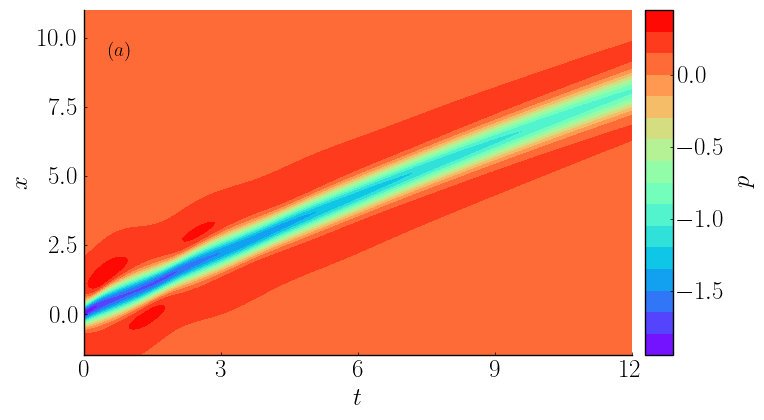

In [230]:
plt = plot(xlabel = L"t", ylabel = L"x", 
           xticks = collect(0.0:3.0:12.0), size = (800, 400), margin = 0.0*Plots.px)


tlist = 0.0:config.Δt:12.0

contourf!(plt, tlist[1:Δstep:end], ssCFD[1:Δstep:end], fullpress[1:Δstep:end,1:Δstep:end], 
         color = :rainbow1,#reverse(cgrad(:viridis)),
         levels = 20,
#          levels = 0.0:0.005:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(findmin(fullpress)[1], findmax(fullpress)[1]), colorbar_title = L"p")

annotate!(0.8, 9.5, text(L"(a)", :black, :bold))

savefig("CFD_xt_pressure.pdf")

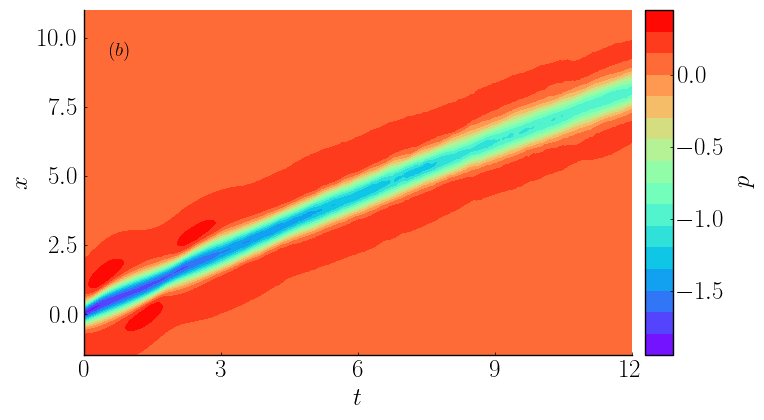

In [231]:
plt = plot(xlabel = L"t", ylabel = L"x", 
           xticks = collect(0.0:3.0:12.0), size = (800, 400), margin = 0.0*Plots.px)


tlist = 0.0:config.Δt:12.0

contourf!(plt, tlist[1:Δstep:end], ssCFD[1:Δstep:end], 0.25*p_lowrank[1:Δstep:end,1:Δstep:end], 
         color = :rainbow1,#reverse(cgrad(:viridis)),
         levels = 20, 
#          levels = 0.0:0.005:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(findmin(fullpress)[1], findmax(fullpress)[1]), colorbar_title = L"p")
annotate!(0.8, 9.5, text(L"(b)", :black, 30))
savefig("CFD_xt_pressure_lowrank_Ne_"*string(Ne)*".pdf")

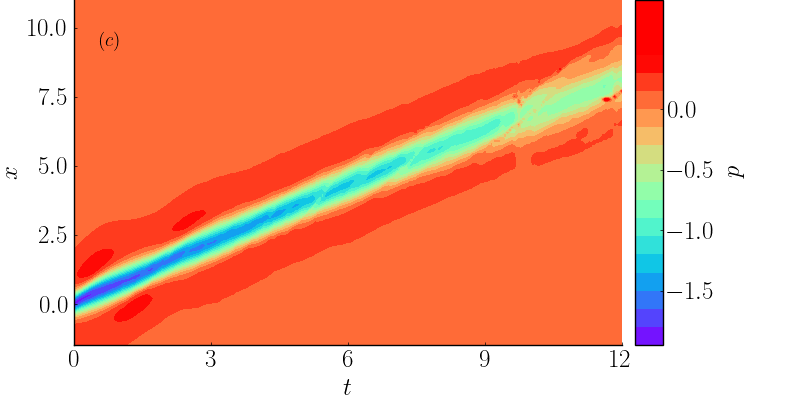

In [240]:
plt = plot(xlabel = L"t", ylabel = L"x", 
           xticks = collect(0.0:3.0:12.0), size = (800, 400), margin = 0.0*Plots.px)


tlist = 0.0:config.Δt:12.0

contourf!(plt, tlist[1:Δstep:end], ssCFD[1:Δstep:end], 0.25*p_enkf[1:Δstep:end,1:Δstep:end], 
         color = :rainbow1,
         levels = 20,
#          levels = 0.0:0.005:0.2,
         background_color_inside = cgrad(:rainbow1)[end],
         clims =(findmin(fullpress)[1], findmax(fullpress)[1]), colorbar_title = L"p")

annotate!(0.8, 9.5, text(L"(c)", :black))

# savefig("CFD_xt_pressure_EnKF_Ne_"*string(Ne)*".pdf")

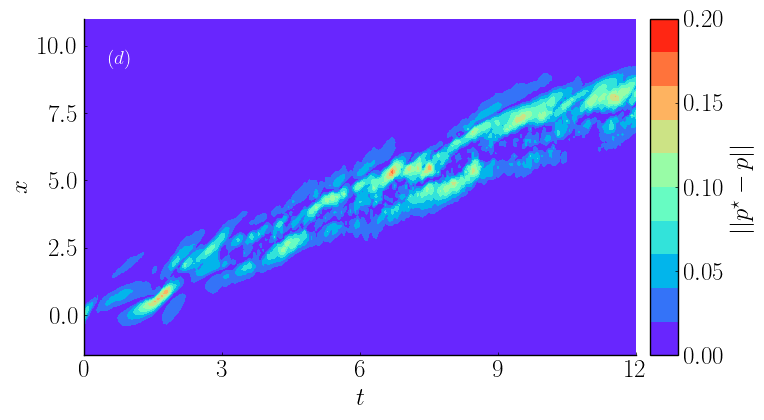

In [236]:
plt = plot(xlabel = L"t", ylabel = L"x", 
           xticks = collect(0.0:3.0:12.0), size = (800, 400), margin = 0.0*Plots.px)

tlist = 0.0:config.Δt:12.0

contourf!(plt, tlist[1:Δstep:end], ssCFD[1:Δstep:end], 
         abs.(0.25*p_lowrank[1:Δstep:end,1:Δstep:end]-fullpress[1:Δstep:end,1:Δstep:end]), 
         color = :rainbow1,#dense,#:linear_worb_100_25_c53_n256,#reverse(cgrad(:grays)),
         levels = 0.0:0.02:0.2,
         background_color_inside = cgrad(:dense)[end],
         clims =(0.0, 0.2), colorbar_title = L"||p^\star - p||")
annotate!(0.8, 9.5, text(L"(d)", :white))
savefig("CFD_xt_error_pressure_lowrank_Ne_"*string(Ne)*".pdf")

# color = reverse(cgrad(:linear_kryw_5_100_c67_n256)),

In [132]:
findmin(abs.(0.25*p_enkf[1:end,1:end]-fullpress[1:end,1:end]))

(1.6627689503057042e-9, CartesianIndex(1042, 1227))

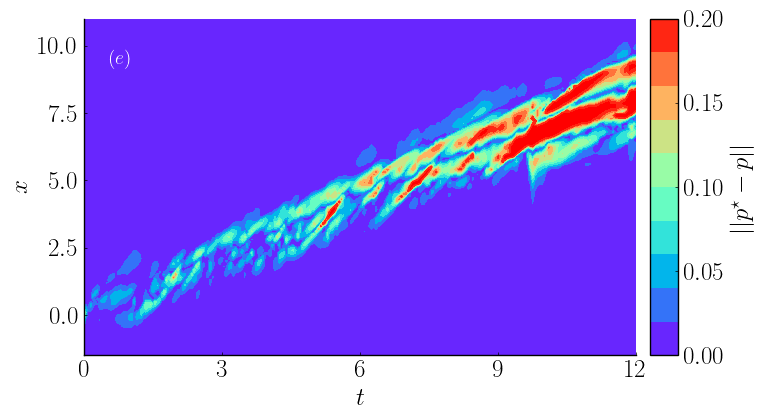

In [237]:
plt = plot(xlabel = L"t", ylabel = L"x", 
           xticks = collect(0.0:3.0:12.0), size = (800, 400), margin = 0.0*Plots.px)

tlist = 0.0:config.Δt:12.0

contourf!(plt, tlist[1:Δstep:end], ssCFD[1:Δstep:end], 
         abs.(0.25*p_enkf[1:Δstep:end,1:Δstep:end]-fullpress[1:Δstep:end,1:Δstep:end]), 
         color = :rainbow1, #:dense,#linear_worb_100_25_c53_n256,
         levels = 0.0:0.02:0.2,
    background_color_inside = cgrad(:rainbow1)[end],
         clims =(0.0, 0.2), colorbar_title = L"||p^\star - p||")
annotate!(0.8, 9.5, text(L"(e)", :white))
savefig("CFD_xt_error_pressure_EnKF_Ne_"*string(Ne)*".pdf")

# color = reverse(cgrad(:linear_kryw_5_100_c67_n256)),

In [20]:
### Figures vortex patch

In [22]:
using CartesianGrids
using ViscousFlow

In [25]:
Re = 300
gridRe = 3

xlim = (-2.0,12.0)
ylim = (-2.0,2.0)
Δx, ΔtCFD = setstepsizes(Re, gridRe = gridRe)

tspan = (0.0,12.0)

sys = NavierStokes(Re,Δx,xlim,ylim,ΔtCFD)

xω, yω = coordinates(ViscousFlow.state(newstate(sys)), sys.grid)

rpatch = 0.5
dpatch = 1.2
Γpatch = 6.0
Upatch = (Γpatch)/(2*π*dpatch)

whist = load("/media/mat/HDD/VortexPatch.jl/notebooks/data/state_vortex_patch_CFD_t_"*string(ceil(Int64, tspan[end]))*"_Re_"*string(ceil(Int64, Re))*
             "_gridRe_"*string(ceil(Int64, gridRe))*"_rpatch_"*string(ceil(Int64, 100*rpatch))*
             "_dpatch_"*string(ceil(Int64, 100*dpatch))*
             "_Gpatch_"*string(ceil(Int64, 100*Γpatch))*".jld")["w"];

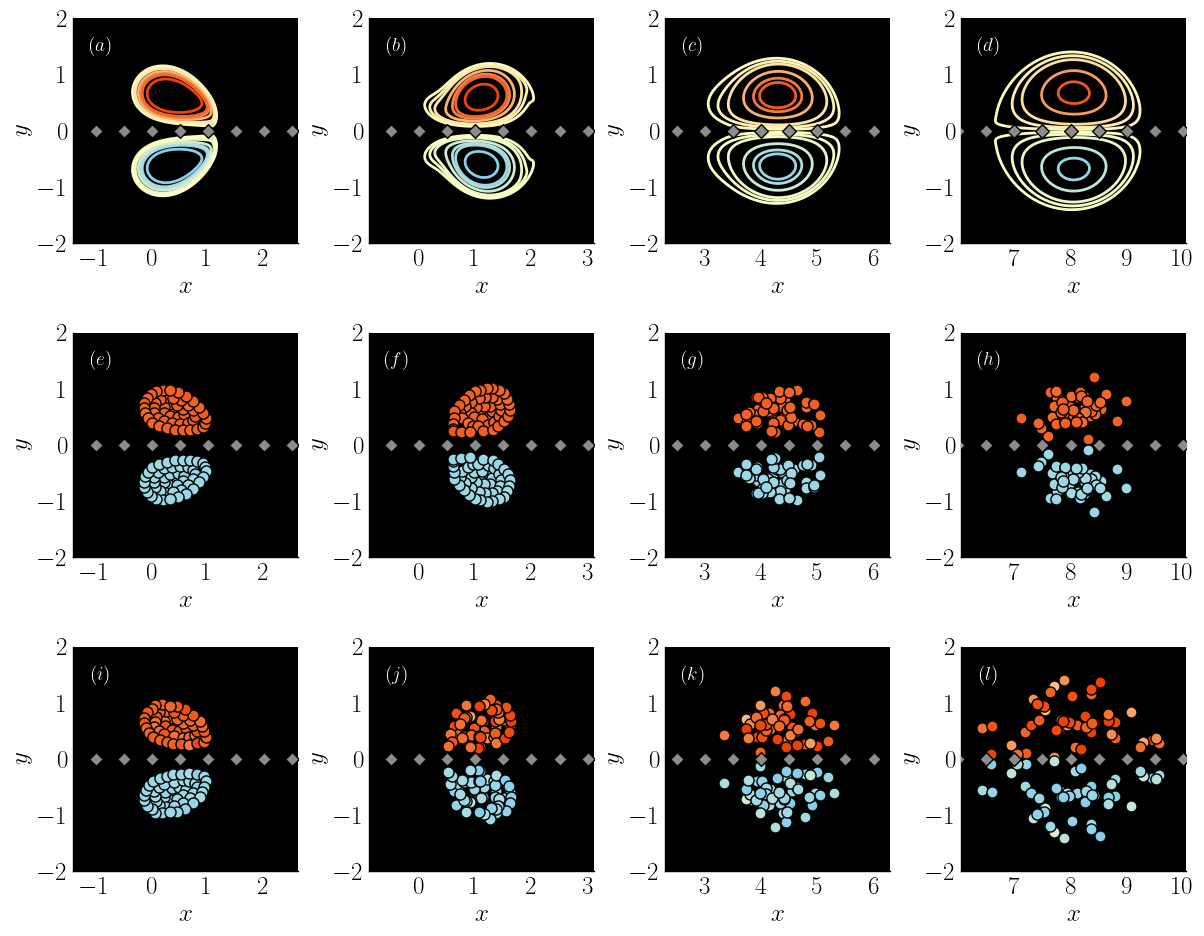

In [145]:
tlist = [0.5; 1.5; 6.0; 12]#collect(0.0:1.0:12.0)


plt = plot(layout = Plots.grid(3, 4), size = (1200, 1200))


xplt = vcat(ones(Int64, 4), 2*ones(Int64, 4))
yplt = vcat(collect(1:4), collect(1:4))

annotationlist = [latexstring("(a)") latexstring("(b)") latexstring("(c)") latexstring("(d)"); 
                  latexstring("(e)") latexstring("(f)") latexstring("(g)") latexstring("(h)");
                  latexstring("(i)") latexstring("(j)") latexstring("(k)") latexstring("(l)")]


plot!(plt[1,4], rightmargin = 20*Plots.px)
plot!(plt[2,4], rightmargin = 20*Plots.px)
plot!(plt[3,4], rightmargin = 20*Plots.px)

for (i, tsnap) in enumerate(tlist)

    nsnapCFD = ceil(Int64, tsnap/0.5)+1
    nsnap = ceil(Int64, tsnap/config.Δt)+1


    idxmax = findmax(abs.(vorticity(ViscousFlow.state(whist[nsnapCFD]), sys, 0.0).data))[2].I[1]
    if (idxmax -(4*rpatch)/Δx) <= 0
        xidx₋ = 1
    else
        xidx₋ = ceil(Int64, idxmax -(4*rpatch)/Δx)
    end

    xidx₊ = ceil(Int64, min(length(xω), idxmax +(4*rpatch)/Δx))
    
    # Plot CFD
    plot!(plt[1,i], xlabel = L"x", ylabel = L"y", 
          xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0), bottommargin = -200*Plots.px) 
    
    contour!(plt[1,i], xω[xidx₋:xidx₊], yω[1:end], vorticity(ViscousFlow.state(whist[nsnapCFD]), sys, 0.0).data[xidx₋:xidx₊,:]', 
            ratio = 1.0, legend = false,
            xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0),
            background_color_inside = :black,
            color = cgrad([:skyblue; colorant"cream"; colorant"orangered2"]),
            xlabel = L"x", ylabel = L"y", colorbar = false, linewidth = 2,
            levels =  sort(vcat(-[2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5], [2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5])))
    
    scatter!(plt[1,i], real.(sensors), imag.(sensors), color = :gray55, markersize = 7, legend = false, 
             markershape = :diamond)
    
    annotate!(plt[1,i], xω[xidx₋] + 0.5, 1.5, text(annotationlist[1,i], :white))
#     annotate!(plt[1,i], xω[idxmax], 2.5, L" t = "*string(tsnap))
    # Plot lowrank
    
    zvlowrank = getfield.(vcat(state_to_lagrange(mean(Xalowrank[nsnap]; dims= 2)[:,1], config)...), :z)
    Γvlowrank = getfield.(vcat(state_to_lagrange(mean(Xalowrank[nsnap]; dims= 2)[:,1], config)...), :S)
    
    plot!(plt[2,i], xlabel = L"x", ylabel = L"y",
               xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0),
               bottommargin = -200*Plots.px, topmargin = -50*Plots.px)
    
    scatter!(plt[2,i], real(zvlowrank), imag(zvlowrank), ratio = 1, legend = false, background_color_inside = :black, 
             markersize = 8, marker_z = Γvlowrank, colorbar = false,
             color = cgrad([:skyblue; colorant"cream"; colorant"orangered2"]),
             clims = (-0.15, 0.15))
    #          levels =  sort(vcat(-[1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5], [1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5])))

    scatter!(plt[2,i], real.(sensors), imag.(sensors), color = :gray55, markersize = 7, legend = false, 
             markershape = :diamond)
    annotate!(plt[2,i], xω[xidx₋] + 0.5, 1.5, text(annotationlist[2,i], :white))

    
    # Plot enkf
        
    zvenkf = getfield.(vcat(state_to_lagrange(mean(Xa[nsnap]; dims= 2)[:,1], config)...), :z)
    Γvenkf = getfield.(vcat(state_to_lagrange(mean(Xa[nsnap]; dims= 2)[:,1], config)...), :S)
    
    plot!(plt[3,i], xlabel = L"x", ylabel = L"y", 
               xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0), topmargin = -50*Plots.px)
    
    scatter!(plt[3,i], real(zvenkf), imag(zvenkf), ratio = 1, legend = false, background_color_inside = :black, 
             markersize = 8, marker_z = Γvenkf, colorbar = false,
             color = cgrad([:skyblue; colorant"cream"; colorant"orangered2"]),
             clims = (-0.15, 0.15))
    #          levels =  sort(vcat(-[1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5], [1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5])))

    scatter!(plt[3,i], real.(sensors), imag.(sensors), color = :gray55, markersize = 7, legend = false, 
             markershape = :diamond)
    annotate!(plt[3,i], xω[xidx₋] + 0.5, 1.5, text(annotationlist[3,i], :white))

end


plt

savefig("comparison_vortex.pdf")

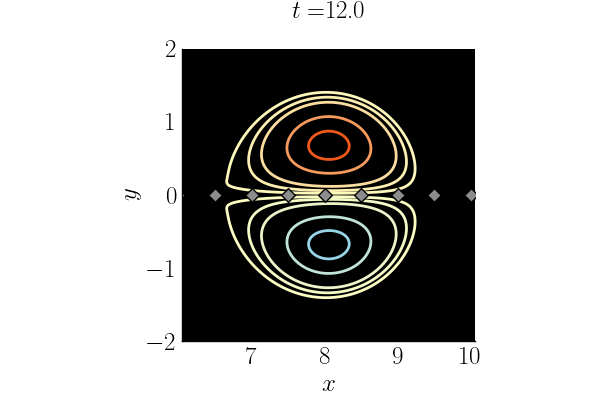

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [66]:
tsnap = 12.0
plt = plot()

nsnapCFD = ceil(Int64, tsnap/0.5)+1
nsnap = ceil(Int64, tsnap/config.Δt)+1


idxmax = findmax(abs.(vorticity(ViscousFlow.state(whist[nsnapCFD]), sys, 0.0).data))[2].I[1]
if (idxmax -(4*rpatch)/Δx) <= 0
    xidx₋ = 1
else
    xidx₋ = ceil(Int64, idxmax -(4*rpatch)/Δx)
end

xidx₊ = ceil(Int64, min(length(xω), idxmax +(4*rpatch)/Δx))
contour!(plt, xω[xidx₋:xidx₊], yω[1:end], vorticity(ViscousFlow.state(whist[nsnapCFD]), sys, 0.0).data[xidx₋:xidx₊,:]', 
    ratio = 1.0, legend = false,
    xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0),
    background_color_inside = :black,
    color = cgrad([:skyblue; colorant"cream"; colorant"orangered2"]),
    xlabel = L"x", ylabel = L"y", colorbar = false, linewidth = 2,
    levels =  sort(vcat(-[2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5], [2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5])),
    topmargin = 40*Plots.px)


# contour!(plt, xω[xidx₋:xidx₊], yω[1:end], vorticity(ViscousFlow.state(whist[nsnap]), sys, 0.0).data[xidx₋:xidx₊,:]',
#          ratio = 1.0, legend = false, levels=0:0, color= cgrad([:black; :black]))

scatter!(plt, real.(sensors), imag.(sensors), color = :gray55, markersize = 7, legend = false, 
         markershape = :diamond)
annotate!(plt, xω[idxmax], 2.5, L"t = "*string(tsnap))
    
#     savefig("CFD_vortexpatch_t_"*string(ceil(Int64, 100*tsnap))*".pdf")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


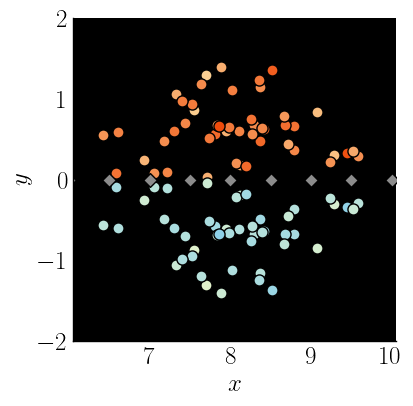

In [86]:
tlist = [0.0; 0.5; 1.5; 3.0; 6.0; 8.0;9.0; 12.0]

@showprogress for tsnap in tlist

    nsnap = ceil(Int64, tsnap/config.Δt)+1
    
    nsnapCFD = ceil(Int64, tsnap/0.5)+1


    idxmax = findmax(abs.(vorticity(ViscousFlow.state(whist[nsnapCFD]), sys, 0.0).data))[2].I[1]
    if (idxmax -(4*rpatch)/Δx) <= 0
        xidx₋ = 1
    else
        xidx₋ = ceil(Int64, idxmax -(4*rpatch)/Δx)
    end

    xidx₊ = ceil(Int64, min(length(xω), idxmax +(4*rpatch)/Δx))


    zv = getfield.(vcat(state_to_lagrange(mean(Xa[nsnap]; dims= 2)[:,1], config)...), :z)
    Γv = getfield.(vcat(state_to_lagrange(mean(Xa[nsnap]; dims= 2)[:,1], config)...), :S)
    plt = plot(xlabel = L"x", ylabel = L"y", 
               xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0), size = (400, 400))
    scatter!(plt, real(zv), imag(zv), ratio = 1, legend = false, background_color_inside = :black, 
             markersize = 8, marker_z = Γv, colorbar = false,
             color = cgrad([:skyblue; colorant"cream"; colorant"orangered2"]), clims = (-0.2, 0.2))
    #          levels =  sort(vcat(-[1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5], [1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5])))

    scatter!(plt, real.(sensors), imag.(sensors), color = :gray55, markersize = 7, legend = false, 
             markershape = :diamond)
#     annotate!(plt, xω[idxmax], 2.5, L"t = "*string(tsnap))
    savefig("snapshot_EnKF_Ne_"*string(Ne)*"_t_"*string(ceil(Int64, 100*tsnap))*".pdf")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


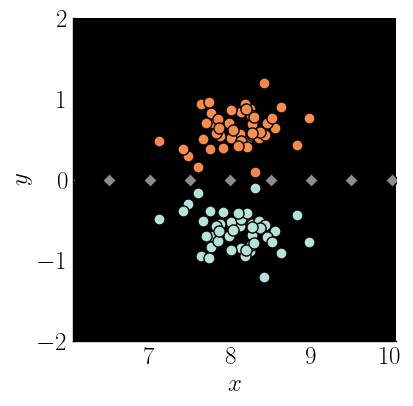

In [87]:
tlist = [0.0; 0.5; 1.5; 3.0; 6.0; 8.0;9.0; 12.0]

@showprogress for tsnap in tlist

    nsnap = ceil(Int64, tsnap/config.Δt)+1
    
    nsnapCFD = ceil(Int64, tsnap/0.5)+1

    idxmax = findmax(abs.(vorticity(ViscousFlow.state(whist[nsnapCFD]), sys, 0.0).data))[2].I[1]
    
    if (idxmax -(4*rpatch)/Δx) <= 0
        xidx₋ = 1
    else
        xidx₋ = ceil(Int64, idxmax -(4*rpatch)/Δx)
    end

    xidx₊ = ceil(Int64, min(length(xω), idxmax +(4*rpatch)/Δx))
    
    zvenkf = getfield.(vcat(state_to_lagrange(mean(Xa[nsnap]; dims= 2)[:,1], config)...), :z)
    Γvenkf = getfield.(vcat(state_to_lagrange(mean(Xa[nsnap]; dims= 2)[:,1], config)...), :S)

    zvlowrank = getfield.(vcat(state_to_lagrange(mean(Xalowrank[nsnap]; dims= 2)[:,1], config)...), :z)
    Γvlowrank = getfield.(vcat(state_to_lagrange(mean(Xalowrank[nsnap]; dims= 2)[:,1], config)...), :S)
    
    
    plt = plot(xlabel = L"x", ylabel = L"y", 
               xlims = (xω[xidx₋], xω[xidx₊]), ylims = (-2.0, 2.0), size = (400, 450))
    scatter!(plt, real(zvlowrank), imag(zvlowrank), ratio = 1, legend = false, background_color_inside = :black, 
             markersize = 8, marker_z = Γvlowrank, colorbar = false,
             color = cgrad([:skyblue; colorant"cream"; colorant"orangered2"]),
             clims = (-0.2, 0.2))
    #          levels =  sort(vcat(-[1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5], [1e-1; 2e-1; 5e-1; 1.0; 3.0; 5; 6.0; 7.5])))

    scatter!(plt, real.(sensors), imag.(sensors), color = :gray55, markersize = 7, legend = false, 
             markershape = :diamond)
#     annotate!(plt, xω[idxmax], 2.5, L"t = "*string(tsnap))
    savefig("snapshot_lowrank_Ne_"*string(Ne)*"_t_"*string(ceil(Int64, 100*tsnap))*".pdf")
end

In [107]:
tsnap = 12
nsnap = ceil(Int64, tsnap/enkf.Δtobs)+1
X_lowrank = deepcopy(Xflowrank[nsnap])
Y_lowrank = zeros(NCFD, Ne)

ϵX = config.ϵX
ϵΓ = config.ϵΓ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ])
ϵmul = MultiplicativeInflation(β)

# Perform state inflation
ϵmul(X_lowrank, 1, Nx)
ϵx(X_lowrank, 0, Nx, config)
Dx = Diagonal(std(X_lowrank[NCFD+1:end,:]; dims = 2)[:,1])
# Dx = I
Dϵ = config.ϵY*I
# Dϵ = I
@time @inbounds for i=1:Ne
    Y_lowrank[:,i] .= pressure(collect(ssCFD) .+ 0.0*im, 
                       vcat(state_to_lagrange(X_lowrank[:,i], config)...), 0.0)# .+ ϵY*randn(NCFD)
end

  0.099056 seconds (18.63 k allocations: 5.148 MiB)


In [108]:
tsnap = 12
nsnap = ceil(Int64, tsnap/enkf.Δtobs)+1
nCFD = ceil(Int64, tsnap/data.Δt)+1

X_enkf = deepcopy(Xf[nsnap])
Y_enkf = zeros(NCFD, Ne)

ϵX = config.ϵX
ϵΓ = config.ϵΓ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ])
ϵmul = MultiplicativeInflation(β)

# Perform state inflation
ϵmul(X_enkf, 1, Nx)
ϵx(X_enkf, 0, Nx, config)
Dx = Diagonal(std(X_enkf[NCFD+1:end,:]; dims = 2)[:,1])
# Dx = I
Dϵ = config.ϵY*I
# Dϵ = I
@time @inbounds for i=1:Ne
    Y_enkf[:,i] .= 0.25*symmetric_pressure(collect(ssCFD), 
                       vcat(state_to_lagrange(X_enkf[:,i], config)...), 0.0) #.+ ϵY*randn(NCFD)
end

  0.081576 seconds (18.27 k allocations: 2.837 MiB)


In [111]:
q5_enkf = zeros(NCFD)
q25_enkf = zeros(NCFD)
q50_enkf = zeros(NCFD)
q75_enkf = zeros(NCFD)
q95_enkf = zeros(NCFD)


for i=1:NCFD
    q5_enkf[i]  = quantile(Y_enkf[i,:], 0.05)
    q25_enkf[i]  = quantile(Y_enkf[i,:], 0.25)
    q50_enkf[i]  = quantile(Y_enkf[i,:], 0.50)
    q75_enkf[i]  = quantile(Y_enkf[i,:], 0.75)
    q95_enkf[i]  = quantile(Y_enkf[i,:], 0.95)
end


q5_lowrank = zeros(NCFD)
q25_lowrank = zeros(NCFD)
q50_lowrank = zeros(NCFD)
q75_lowrank = zeros(NCFD)
q95_lowrank = zeros(NCFD)


for i=1:NCFD
    q5_lowrank[i]  = quantile(Y_lowrank[i,:], 0.05)
    q25_lowrank[i]  = quantile(Y_lowrank[i,:], 0.25)
    q50_lowrank[i]  = quantile(Y_lowrank[i,:], 0.50)
    q75_lowrank[i]  = quantile(Y_lowrank[i,:], 0.75)
    q95_lowrank[i]  = quantile(Y_lowrank[i,:], 0.95)
end

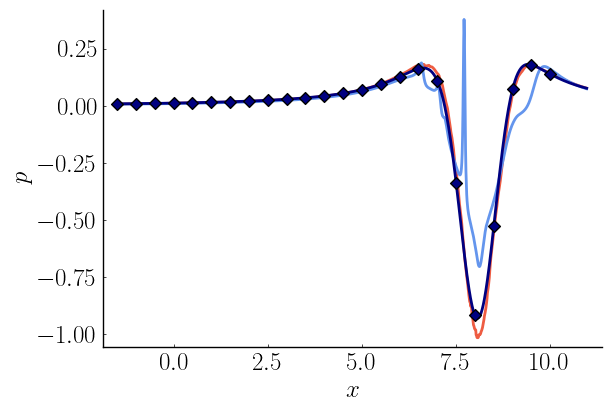

In [112]:
plt = plot(xlabel = L"x", ylabel = L"p", legend = false)

# plot!(ssCFD, q5_lowrank, linewidth = 1, linestyle = :dot, color = colorant"purple3")
# plot!(ssCFD, q5_lowrank, linewidth = 0.5, linestyle = :dash, color = colorant"tomato2", label = "")
plot!(ssCFD, q50_lowrank, linewidth = 2, linestyle = :solid, color = colorant"tomato2", label = "Low-rank EnKF")
# plot!(ssCFD, q95_lowrank, fillrange = q5_lowrank, alpha = 0.5, linewidth = 0.5, linestyle = :dash, 
#       color = colorant"tomato2", label = "")
# plot!(ssCFD, q95_lowrank, linewidth = 1, linestyle = :dot, color = colorant"purple3")

# plot!(ssCFD, q5_enkf, linewidth = 1, linestyle = :dot, color = colorant"purple3")
# plot!(ssCFD, q5_enkf, linewidth = 0.5, linestyle = :dash, color = colorant"cornflowerblue", label = "")
plot!(ssCFD, q50_enkf, linewidth = 2, linestyle = :solid, color = colorant"cornflowerblue", label = "EnKF")
# plot!(ssCFD, q95_enkf,  fillrange = q5_enkf, alpha = 0.5, linewidth = 0.5, linestyle = :dash, 
#       color = colorant"cornflowerblue", label = "")
# plot!(ssCFD, q95_enkf, linewidth = 1, linestyle = :dot, color = colorant"orangered2")

plot!(ssCFD, fullpress[:,nCFD], linewidth = 2, color = :navyblue, label = "CFD")
scatter!(ssCFD[idxCFD], fullpress[idxCFD,nCFD], markersize = 6, shape = :diamond, color = :navyblue, label = "")

savefig("pressure_reconstruction.pdf")